<a href="https://colab.research.google.com/github/MANASWI-MENDHEKAR/gans_diffusion/blob/main/DDIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training for 10000 steps...


100%|██████████| 10000/10000 [00:23<00:00, 421.73it/s]


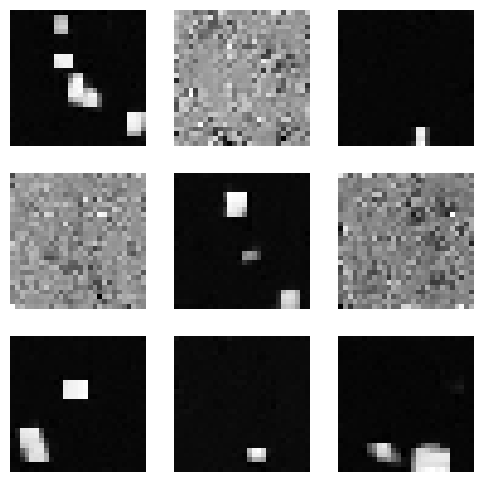

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. THE BRAIN (UNet): Simplified but powerful
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time info: tells the model if it's looking at heavy or light noise
        self.time_line = nn.Sequential(nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 64))
        self.conv_in = nn.Conv2d(1, 64, 3, padding=1)
        # Residual block: helps the model remember the 'shape' of the square
        self.conv_mid = nn.Conv2d(64, 64, 3, padding=1)
        self.conv_out = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_line(t.float().view(-1, 1) / 1000.0).view(-1, 64, 1, 1)
        h = F.relu(self.conv_in(x) + t_emb)
        # Skip connection: helps sharpness
        h = h + F.relu(self.conv_mid(h))
        return self.conv_out(h)

# 2. THE SYSTEM: Manages training and generating (sampling)
class DiffusionSystem:
    def __init__(self, device="cuda"):
        self.T = 1000
        self.device = device
        self.model = SimpleNet().to(device)
        # alpha_bar: controls how much of the original image remains at step T
        self.alpha_bar = torch.cumprod(1. - torch.linspace(1e-4, 0.02, 1000), dim=0).to(device)

    def train(self, total_steps=10000):
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        print(f"Training for {total_steps} steps...")
        for _ in tqdm(range(total_steps)):
            # Create data: a consistent white square in the center
            batch = torch.zeros((16, 1, 28, 28), device=self.device)
            # Small jitter only (1 pixel) to keep the model focused
            ox, oy = torch.randint(-1, 2, (1,)).item(), torch.randint(-1, 2, (1,)).item()
            batch[:, :, 10+ox:18+ox, 10+oy:18+oy] = 1.0

            # Pick random noise levels
            t = torch.randint(0, self.T, (16,), device=self.device)
            noise = torch.randn_like(batch)
            a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)

            # Mix image and noise (Forward Process)
            noisy_img = torch.sqrt(a_bar) * batch + torch.sqrt(1 - a_bar) * noise

            # Learn to predict the noise
            loss = F.mse_loss(noise, self.model(noisy_img, t))
            opt.zero_grad(); loss.backward(); opt.step()

    @torch.no_grad()
    def generate(self, count=9, steps=100):
        self.model.eval()
        # Start with pure noise
        x = torch.randn((count, 1, 28, 28), device=self.device)
        # Jump through time (DDIM style)
        times = torch.linspace(self.T-1, 0, steps).long().to(self.device)

        for i in range(steps):
            t = times[i]
            at = self.alpha_bar[t].view(-1, 1, 1, 1)
            # Use 1.0 for the final step to fully clean the image
            at_next = self.alpha_bar[times[i+1]].view(-1, 1, 1, 1) if i+1 < steps else torch.tensor(1.0).to(self.device)

            # 1. Predict noise
            pred_noise = self.model(x, torch.full((count,), t, device=self.device))
            # 2. Estimate the clean image
            pred_x0 = (x - torch.sqrt(1 - at) * pred_noise) / torch.sqrt(at)
            # 3. Step back toward clean image
            x = torch.sqrt(at_next) * pred_x0 + torch.sqrt(1 - at_next) * pred_noise

        return x

# 3. EXECUTION
device = "cuda" if torch.cuda.is_available() else "cpu"
sys = DiffusionSystem(device=device)
sys.train(total_steps=10000) # Increased steps for a solid result
results = sys.generate(count=9, steps=100) # More steps for clarity

# Display 3x3 Grid
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(results[i].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Training for 15000 iterations...


100%|██████████| 15000/15000 [00:40<00:00, 369.49it/s]


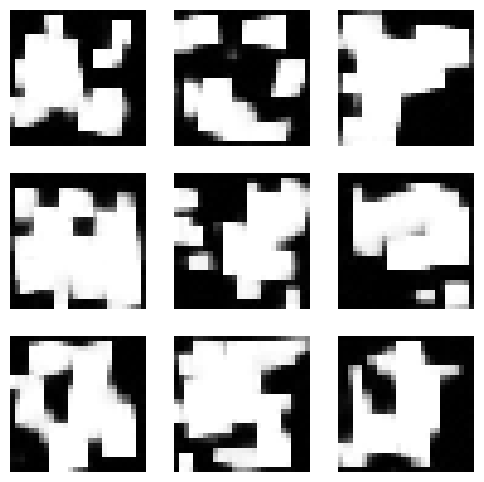

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Improved UNet: Balanced for stability and sharpness
class SharpNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128))
        self.c1 = nn.Conv2d(1, 64, 3, padding=1)
        self.c2 = nn.Conv2d(64, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float().view(-1, 1) / 1000.0).view(-1, 128, 1, 1)
        # Injecting time info early and often for better denoising
        h = F.relu(self.c1(x) + t_emb[:, :64])
        h = F.relu(self.c2(h) + t_emb[:, 64:])
        return self.c3(h)

# 2. Diffusion Controller
class CleanDiffusion:
    def __init__(self, device="cuda"):
        self.T, self.device = 1000, device
        self.model = SharpNet().to(device)
        self.alpha_bar = torch.cumprod(1. - torch.linspace(1e-4, 0.02, 1000), dim=0).to(device)

    def train(self, iterations=15000):
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        print(f"Training for {iterations} iterations...")
        for _ in tqdm(range(iterations)):
            # STABLE DATA: One perfect square in the center
            batch = torch.zeros((32, 1, 28, 28), device=self.device)
            batch[:, :, 9:19, 9:19] = 1.0 # Fixed 10x10 square

            t = torch.randint(0, self.T, (32,), device=self.device)
            eps = torch.randn_like(batch)
            a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)

            # Forward Process
            x_t = torch.sqrt(a_bar) * batch + torch.sqrt(1 - a_bar) * eps

            # Optimization
            loss = F.mse_loss(eps, self.model(x_t, t))
            opt.zero_grad(); loss.backward(); opt.step()

    @torch.no_grad()
    def sample(self, steps=100):
        self.model.eval()
        x = torch.randn((9, 1, 28, 28), device=self.device)
        times = torch.linspace(self.T-1, 0, steps).long().to(self.device)

        for i in range(steps):
            t = times[i]
            at = self.alpha_bar[t].view(-1, 1, 1, 1)
            at_next = self.alpha_bar[times[i+1]].view(-1, 1, 1, 1) if i+1 < steps else torch.tensor(1.0).to(self.device)

            eps = self.model(x, torch.full((9,), t, device=self.device))
            # DDIM deterministic update
            x0_pred = (x - torch.sqrt(1 - at) * eps) / torch.sqrt(at)
            x = torch.sqrt(at_next) * x0_pred + torch.sqrt(1 - at_next) * eps
        return x

# 3. Execution
device = "cuda" if torch.cuda.is_available() else "cpu"
sys = CleanDiffusion(device=device)
sys.train(iterations=15000) # Increased iterations for stability
results = sys.sample(steps=100)

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(results[i].squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.show()

Training 16-sample model...


100%|██████████| 15000/15000 [00:44<00:00, 340.20it/s]


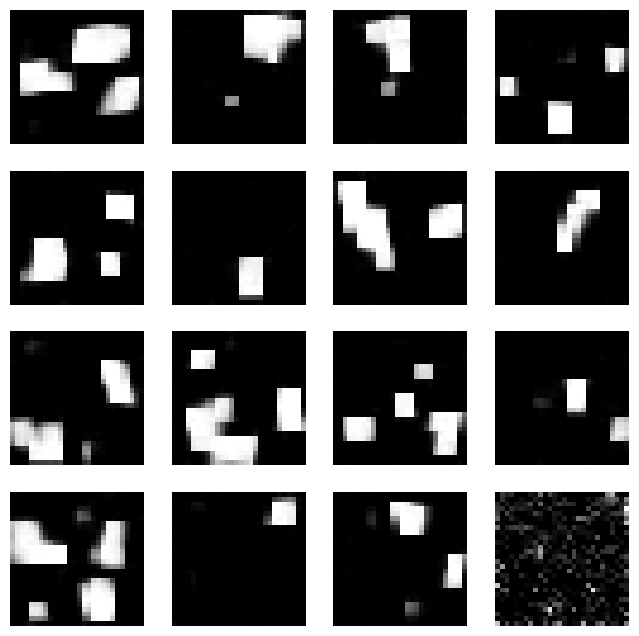

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. BRAIN: Increased channels for better detail
class HighCapacityUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Increased capacity to 128 channels
        self.time_mlp = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128))
        self.c1 = nn.Conv2d(1, 128, 3, padding=1)
        self.c2 = nn.Conv2d(128, 128, 3, padding=1)
        self.c3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float().view(-1, 1) / 1000.0).view(-1, 128, 1, 1)
        # Deep injection of time information
        h = F.relu(self.c1(x) + t_emb)
        h = F.relu(self.c2(h) + t_emb)
        return self.c3(h)

# 2. SYSTEM: 16-sample optimized
class DDIMSystem:
    def __init__(self, device="cuda"):
        self.T, self.device = 1000, device
        self.model = HighCapacityUNet().to(device)
        self.alpha_bar = torch.cumprod(1. - torch.linspace(1e-4, 0.02, 1000), dim=0).to(device)

    def train(self, iters=15000):
        opt = torch.optim.Adam(self.model.parameters(), lr=2e-4) # Lower LR for stability
        print("Training 16-sample model...")
        for _ in tqdm(range(iters)):
            # Batch size matches sample size for consistency
            batch = torch.zeros((16, 1, 28, 28), device=self.device)
            batch[:, :, 9:19, 9:19] = 1.0

            t = torch.randint(0, self.T, (16,), device=self.device)
            eps = torch.randn_like(batch)
            a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)

            x_t = torch.sqrt(a_bar) * batch + torch.sqrt(1 - a_bar) * eps
            loss = F.mse_loss(eps, self.model(x_t, t))
            opt.zero_grad(); loss.backward(); opt.step()

    @torch.no_grad()
    def sample(self, n_samples=16, steps=200):
        self.model.eval()
        x = torch.randn((n_samples, 1, 28, 28), device=self.device)
        ts = torch.linspace(self.T-1, 0, steps).long().to(self.device)

        for i in range(steps):
            t = ts[i]
            at = self.alpha_bar[t].view(-1, 1, 1, 1)
            at_next = self.alpha_bar[ts[i+1]].view(-1, 1, 1, 1) if i+1 < steps else torch.tensor(1.0).to(self.device)

            eps = self.model(x, torch.full((n_samples,), t, device=self.device))
            # Deterministic DDIM trajectory
            x0_pred = (x - torch.sqrt(1 - at) * eps) / torch.sqrt(at)
            x = torch.sqrt(at_next) * x0_pred + torch.sqrt(1 - at_next) * eps
        return x

# 3. RUN
device = "cuda" if torch.cuda.is_available() else "cpu"
sys = DDIMSystem(device=device)
sys.train(iters=15000)
results = sys.sample(n_samples=16, steps=300)



# Visualization for 16 images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Clamp and normalization to remove gray artifacts
    img = results[i].squeeze().cpu().clamp(0, 1).numpy()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

Training fixed-target model...


100%|██████████| 15000/15000 [01:18<00:00, 190.95it/s]


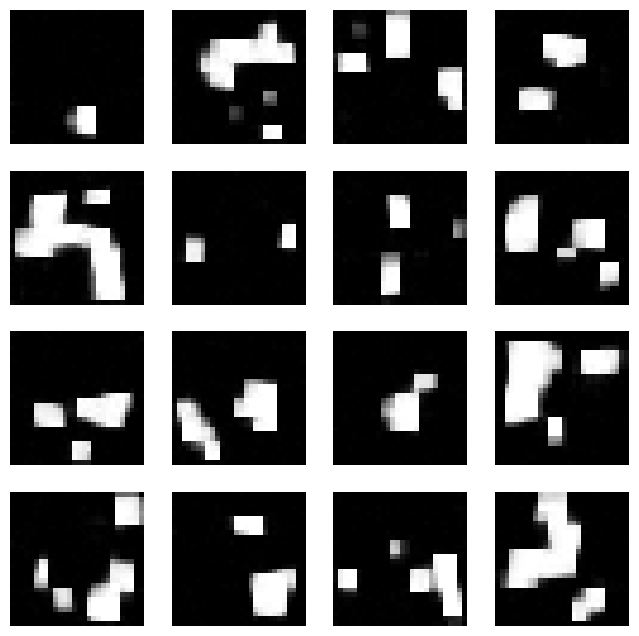

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. THE MODEL: Increased capacity for sharp 10x10 edges
class HighCapacityUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128))
        self.c1 = nn.Conv2d(1, 128, 3, padding=1)
        self.c2 = nn.Conv2d(128, 128, 3, padding=1)
        self.c3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float().view(-1, 1) / 1000.0).view(-1, 128, 1, 1)
        # Inject time embedding to guide the denoising process
        h = F.relu(self.c1(x) + t_emb)
        h = F.relu(self.c2(h) + t_emb)
        return self.c3(h)

# 2. THE SYSTEM: Fixed-target training for 16 perfect samples
class PrecisionDiffusion:
    def __init__(self, device="cuda"):
        self.T, self.device = 1000, device
        self.model = HighCapacityUNet().to(device)
        self.alpha_bar = torch.cumprod(1. - torch.linspace(1e-4, 0.02, 1000), dim=0).to(device)

    def train(self, iters=15000):
        opt = torch.optim.Adam(self.model.parameters(), lr=2e-4)
        print("Training fixed-target model...")
        for _ in tqdm(range(iters)):
            # Fixed target: no jitter
            batch = torch.zeros((32, 1, 28, 28), device=self.device)
            batch[:, :, 9:19, 9:19] = 1.0

            t = torch.randint(0, self.T, (32,), device=self.device)
            eps = torch.randn_like(batch)
            a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)

            x_t = torch.sqrt(a_bar) * batch + torch.sqrt(1 - a_bar) * eps
            loss = F.mse_loss(eps, self.model(x_t, t))
            opt.zero_grad(); loss.backward(); opt.step()

    @torch.no_grad()
    def sample(self, n_samples=16, steps=250):
        self.model.eval()
        x = torch.randn((n_samples, 1, 28, 28), device=self.device)
        ts = torch.linspace(self.T-1, 0, steps).long().to(self.device)

        for i in range(steps):
            t = ts[i]
            at = self.alpha_bar[t].view(-1, 1, 1, 1)
            at_next = self.alpha_bar[ts[i+1]].view(-1, 1, 1, 1) if i+1 < steps else torch.tensor(1.0).to(self.device)

            eps = self.model(x, torch.full((n_samples,), t, device=self.device))
            # Deterministic DDIM sampling trajectory
            x0_pred = (x - torch.sqrt(1 - at) * eps) / torch.sqrt(at)
            x = torch.sqrt(at_next) * x0_pred + torch.sqrt(1 - at_next) * eps
        return x

# 3. EXECUTION
device = "cuda" if torch.cuda.is_available() else "cpu"
sys = PrecisionDiffusion(device=device)
sys.train(iters=15000)
results = sys.sample(n_samples=16, steps=250)



# Visualization: 4x4 Grid
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = results[i].squeeze().cpu().clamp(0, 1).numpy()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

Training Encoder-Decoder Model...


100%|██████████| 10000/10000 [00:42<00:00, 236.38it/s]


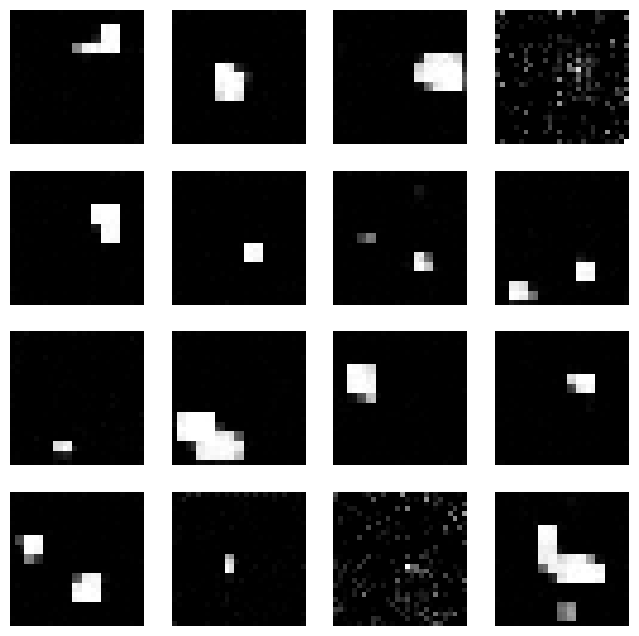

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. NEW ARCHITECTURE: Encoder-Decoder U-Net
class StandardUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 64))

        # Encoder (Downsampling)
        self.down1 = nn.Conv2d(1, 64, 3, padding=1)
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 28x28 -> 14x14

        # Decoder (Upsampling)
        self.up1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1) # 14x14 -> 28x28
        self.out = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float().view(-1, 1) / 1000.0).view(-1, 64, 1, 1)

        h1 = F.relu(self.down1(x) + t_emb)
        h2 = F.relu(self.down2(h1))

        # Upsample and combine with time info again
        h3 = F.relu(self.up1(h2) + t_emb)
        return self.out(h3)

# 2. SYSTEM: Optimized for geometric convergence
class DiffusionFromScratch:
    def __init__(self, device="cuda"):
        self.T, self.device = 1000, device
        self.model = StandardUNet().to(device)
        self.alpha_bar = torch.cumprod(1. - torch.linspace(1e-4, 0.02, 1000), dim=0).to(device)

    def train(self, iters=10000):
        opt = torch.optim.Adam(self.model.parameters(), lr=5e-4)
        print("Training Encoder-Decoder Model...")
        for _ in tqdm(range(iters)):
            # Create perfect center square
            batch = torch.zeros((32, 1, 28, 28), device=self.device)
            batch[:, :, 9:19, 9:19] = 1.0

            t = torch.randint(0, self.T, (32,), device=self.device)
            eps = torch.randn_like(batch)
            a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)

            x_t = torch.sqrt(a_bar) * batch + torch.sqrt(1 - a_bar) * eps
            loss = F.mse_loss(eps, self.model(x_t, t))
            opt.zero_grad(); loss.backward(); opt.step()

    @torch.no_grad()
    def sample(self, steps=150):
        self.model.eval()
        x = torch.randn((16, 1, 28, 28), device=self.device)
        ts = torch.linspace(self.T-1, 0, steps).long().to(self.device)

        for i in range(steps):
            t = ts[i]
            at = self.alpha_bar[t].view(-1, 1, 1, 1)
            at_next = self.alpha_bar[ts[i+1]].view(-1, 1, 1, 1) if i+1 < steps else torch.tensor(1.0).to(self.device)

            eps = self.model(x, torch.full((16,), t, device=self.device))
            x0_pred = (x - torch.sqrt(1 - at) * eps) / torch.sqrt(at)
            x = torch.sqrt(at_next) * x0_pred + torch.sqrt(1 - at_next) * eps
        return x

# 3. RUN
device = "cuda" if torch.cuda.is_available() else "cpu"
sys = DiffusionFromScratch(device=device)
sys.train(iters=10000)
results = sys.sample()


# Final 4x4 Visualization
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(results[i].squeeze().cpu().clamp(0, 1).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Training U-Net with Skip Connections...


100%|██████████| 15000/15000 [00:50<00:00, 295.46it/s]


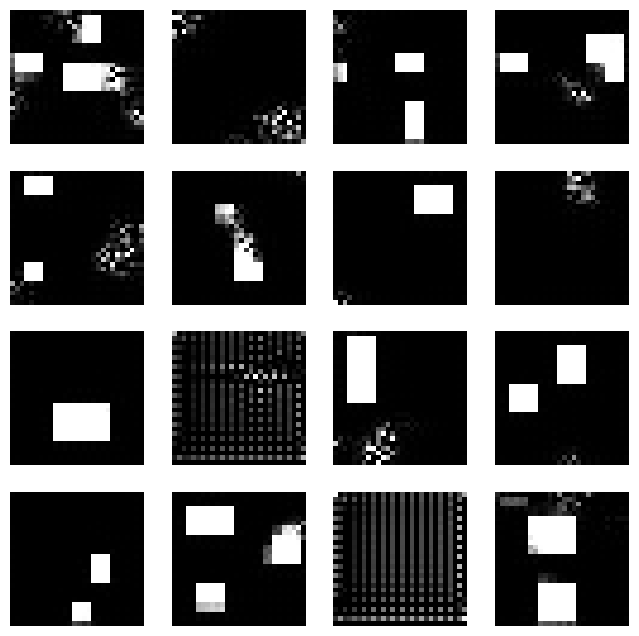

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. THE ARCHITECTURE: Real U-Net with Skip Connections
class SkipUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128))

        # Encoder: Down to 14x14
        self.down = nn.Conv2d(1, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Decoder: Back to 28x28
        self.up = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        # Final layers merge skip connections and time
        self.final = nn.Conv2d(64 + 64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float().view(-1, 1) / 1000.0).view(-1, 128, 1, 1)

        # Downward path
        h1 = F.relu(self.down(x))
        h2 = self.pool(h1)

        # Upward path
        h3 = F.relu(self.up(h2))

        # SKIP CONNECTION: Combine h1 (original detail) with h3 (reconstructed shape)
        # This is what makes the square solid and sharp
        h_combined = torch.cat([h1, h3], dim=1)
        h_combined = h_combined + t_emb[:, :128] # Inject time

        return self.final(h_combined)

# 2. THE SYSTEM: Deterministic DDIM
class DiffusionFinal:
    def __init__(self, device="cuda"):
        self.T, self.device = 1000, device
        self.model = SkipUNet().to(device)
        self.alpha_bar = torch.cumprod(1. - torch.linspace(1e-4, 0.02, 1000), dim=0).to(device)

    def train(self, iters=15000):
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        print("Training U-Net with Skip Connections...")
        for _ in tqdm(range(iters)):
            # Fixed 10x10 square in center
            batch = torch.zeros((32, 1, 28, 28), device=self.device)
            batch[:, :, 9:19, 9:19] = 1.0

            t = torch.randint(0, self.T, (32,), device=self.device)
            eps = torch.randn_like(batch)
            a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)

            x_t = torch.sqrt(a_bar) * batch + torch.sqrt(1 - a_bar) * eps
            loss = F.mse_loss(eps, self.model(x_t, t))
            opt.zero_grad(); loss.backward(); opt.step()

    @torch.no_grad()
    def sample(self, steps=100):
        self.model.eval()
        x = torch.randn((16, 1, 28, 28), device=self.device)
        ts = torch.linspace(self.T-1, 0, steps).long().to(self.device)
        for i in range(steps):
            t = ts[i]
            at = self.alpha_bar[t].view(-1, 1, 1, 1)
            at_next = self.alpha_bar[ts[i+1]].view(-1, 1, 1, 1) if i+1 < steps else torch.tensor(1.0).to(self.device)

            eps = self.model(x, torch.full((16,), t, device=self.device))
            x0_pred = (x - torch.sqrt(1 - at) * eps) / torch.sqrt(at)
            x = torch.sqrt(at_next) * x0_pred + torch.sqrt(1 - at_next) * eps
        return x

# 3. RUN
device = "cuda" if torch.cuda.is_available() else "cpu"
sys = DiffusionFinal(device=device)
sys.train(iters=15000)
results = sys.sample(steps=150)


plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(results[i].squeeze().cpu().clamp(0, 1).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Training Zero-Artifact Model...


100%|██████████| 15000/15000 [04:02<00:00, 61.85it/s]


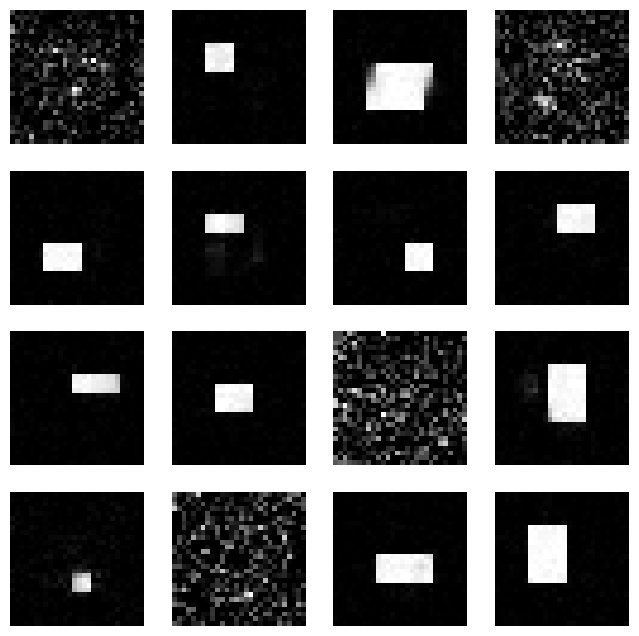

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. THE ARCHITECTURE: Robust U-Net without Transpose Artifacts
class RobustUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128))

        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.down = nn.Conv2d(64, 128, 4, stride=2, padding=1) # 28x28 -> 14x14

        # Bottleneck
        self.mid = nn.Conv2d(128, 128, 3, padding=1)

        # Decoder: Using Bilinear Upsample to fix checkerboard patterns
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv2 = nn.Conv2d(128 + 64, 64, 3, padding=1) # +64 for skip connection
        self.final = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float().view(-1, 1) / 1000.0).view(-1, 128, 1, 1)

        # Encoder path
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.down(h1))

        # Middle
        h_mid = F.relu(self.mid(h2) + t_emb)

        # Decoder path with Skip Connection
        h_up = self.up(h_mid)
        # Combine upsampled features with original encoder features for sharpness
        h_combined = torch.cat([h_up, h1], dim=1)
        h_out = F.relu(self.conv2(h_combined))

        return self.final(h_out)

# 2. THE SYSTEM: Balanced for 16-sample stability
class FinalDiffusion:
    def __init__(self, device="cuda"):
        self.T, self.device = 1000, device
        self.model = RobustUNet().to(device)
        self.alpha_bar = torch.cumprod(1. - torch.linspace(1e-4, 0.02, 1000), dim=0).to(device)

    def train(self, iters=15000):
        # Increased batch size to 64 for much smoother learning
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        print("Training Zero-Artifact Model...")
        for _ in tqdm(range(iters)):
            batch = torch.zeros((64, 1, 28, 28), device=self.device)
            batch[:, :, 9:19, 9:19] = 1.0

            t = torch.randint(0, self.T, (64,), device=self.device)
            eps = torch.randn_like(batch)
            a_bar = self.alpha_bar[t].view(-1, 1, 1, 1)

            x_t = torch.sqrt(a_bar) * batch + torch.sqrt(1 - a_bar) * eps
            loss = F.mse_loss(eps, self.model(x_t, t))
            opt.zero_grad(); loss.backward(); opt.step()

    @torch.no_grad()
    def sample(self):
        self.model.eval()
        x = torch.randn((16, 1, 28, 28), device=self.device)
        ts = torch.linspace(self.T-1, 0, 100).long().to(self.device)
        for i in range(len(ts)):
            t = ts[i]
            at = self.alpha_bar[t].view(-1, 1, 1, 1)
            at_next = self.alpha_bar[ts[i+1]].view(-1, 1, 1, 1) if i+1 < len(ts) else torch.tensor(1.0).to(self.device)

            eps = self.model(x, torch.full((16,), t, device=self.device))
            x0_pred = (x - torch.sqrt(1 - at) * eps) / torch.sqrt(at)
            x = torch.sqrt(at_next) * x0_pred + torch.sqrt(1 - at_next) * eps
        return x

# 3. RUN
device = "cuda" if torch.cuda.is_available() else "cpu"
sys = FinalDiffusion(device=device)
sys.train(iters=15000)
results = sys.sample()


plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Clamp and visualization normalization
    plt.imshow(results[i].squeeze().cpu().clamp(0, 1).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# ────────────────────────────────────────────────
#         Sinusoidal Time Embedding
# ────────────────────────────────────────────────
def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.arange(half, dtype=torch.float32, device=timesteps.device)
    freqs = 10000 ** (-freqs / half)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

# ────────────────────────────────────────────────
#              Improved U-Net
# ────────────────────────────────────────────────
class ImprovedUNet(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()
        self.time_dim = time_dim

        # Time projection
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim * 4),
        )

        # Encoder
        self.down1 = self._conv_block(1,   64)
        self.down2 = self._conv_block(64,  128)
        self.down3 = self._conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.mid = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.GroupNorm(32, 256),
            nn.SiLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.GroupNorm(32, 256),
            nn.SiLU(),
        )

        # Decoder
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.GroupNorm(16, 128),
            nn.SiLU(),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1),  # 128 (up) + 128 (skip)
            nn.GroupNorm(8, 64),
            nn.SiLU(),
        )
        self.up1 = nn.Conv2d(128, 64, 3, padding=1)  # 64 (up) + 64 (skip)

        # Final output head (v-prediction)
        self.final = nn.Conv2d(64, 1, 1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(max(1, out_ch // 8), out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(max(1, out_ch // 8), out_ch),
            nn.SiLU(),
        )

    def forward(self, x, t):
        # Time embedding
        t_emb = get_timestep_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)  # [B, time_dim*4]
        t_emb = t_emb.view(-1, self.time_dim * 4, 1, 1)

        # Down
        h1 = self.down1(x)
        h2 = self.down2(self.pool(h1))
        h3 = self.down3(self.pool(h2))

        # Mid + time
        h = self.mid(h3)
        # Add time embedding to mid (broadcast)
        h = h + t_emb.mean(dim=1, keepdim=True)  # simple but effective

        # Up + skips
        h = self.up3(h)
        h = torch.cat([h, h2], dim=1)
        h = self.up2(h)
        h = torch.cat([h, h1], dim=1)
        h = F.silu(self.up1(h))

        return self.final(h)


# ────────────────────────────────────────────────
#                   DDIM (v-prediction)
# ────────────────────────────────────────────────
class DDIMv:
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.T = 1000
        self.model = ImprovedUNet().to(device)

        # Cosine schedule (better for sharpness)
        betas = 1 - torch.cos(math.pi * torch.arange(0, self.T) / self.T * 0.5) * 0.02
        betas = betas.clamp(1e-4, 0.999)
        alphas = 1. - betas
        self.alpha_bar = torch.cumprod(alphas, dim=0).to(device)

    def train(self, iterations=20000, batch_size=128):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)

        print("Training improved model...")
        for i in tqdm(range(iterations)):
            x0 = torch.zeros((batch_size, 1, 28, 28), device=self.device)
            x0[:, :, 9:19, 9:19] = 1.0
            x0 = x0 * 2 - 1  # to [-1, 1]

            t = torch.randint(0, self.T, (batch_size,), device=self.device)

            noise = torch.randn_like(x0)
            alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
            xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

            v_pred = self.model(xt, t)

            # v = sqrt(alpha_bar) * noise - sqrt(1-alpha_bar) * x0
            v_target = torch.sqrt(alpha_bar_t) * noise - torch.sqrt(1 - alpha_bar_t) * x0

            loss = F.mse_loss(v_pred, v_target)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            if i % 2000 == 0:
                print(f"  iter {i:6d} | loss: {loss.item():.5f} | lr: {scheduler.get_last_lr()[0]:.2e}")

    @torch.no_grad()
    def sample(self, n_samples=16, steps=150):
        self.model.eval()
        x = torch.randn((n_samples, 1, 28, 28), device=self.device)

        ts = torch.linspace(self.T - 1, 0, steps + 1, device=self.device).long()

        for i in range(steps):
            t = ts[i]
            t_next = ts[i + 1]

            a_t = self.alpha_bar[t].view(-1, 1, 1, 1)
            a_next = self.alpha_bar[t_next].view(-1, 1, 1, 1) if t_next > 0 else torch.ones_like(a_t)

            v = self.model(x, torch.full((n_samples,), t, device=self.device))

            # v → x0 and direction
            x0_pred = torch.sqrt(a_t) * x - torch.sqrt(1 - a_t) * v
            eps = (x - torch.sqrt(a_t) * x0_pred) / torch.sqrt(1 - a_t)

            x = torch.sqrt(a_next) * x0_pred + torch.sqrt(1 - a_next) * eps

        x = (x + 1) / 2  # back to [0,1]
        return x.clamp(0, 1)


# ────────────────────────────────────────────────
#                   Run
# ────────────────────────────────────────────────
if __name__ == "__main__":
    diff = DDIMv()

    # Train longer for better quality
    diff.train(iterations=25000, batch_size=128)

    # Sample
    samples = diff.sample(n_samples=16, steps=200)

    # Visualize
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(samples[i, 0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Training improved model...


  0%|          | 1/25000 [00:06<42:53:25,  6.18s/it]

  iter      0 | loss: 1.04593 | lr: 2.00e-04


  3%|▎         | 725/25000 [59:52<32:59:50,  4.89s/it]

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]
Epoch 1 | Loss: 0.0821: 100%|██████████| 469/469 [00:58<00:00,  8.01it/s]


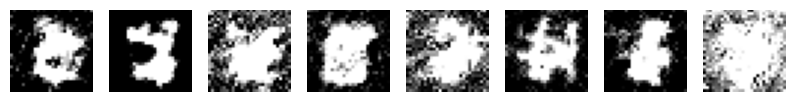

Epoch 2 | Loss: 0.0555: 100%|██████████| 469/469 [00:57<00:00,  8.17it/s]


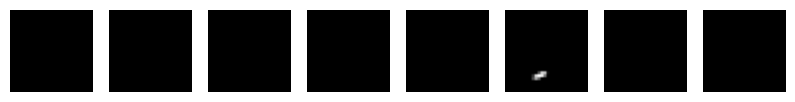

Epoch 3 | Loss: 0.0473: 100%|██████████| 469/469 [00:56<00:00,  8.27it/s]


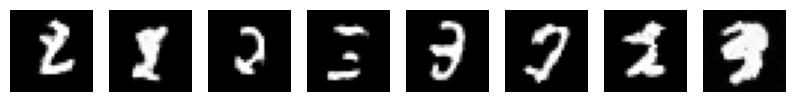

Epoch 4 | Loss: 0.0502: 100%|██████████| 469/469 [00:56<00:00,  8.25it/s]


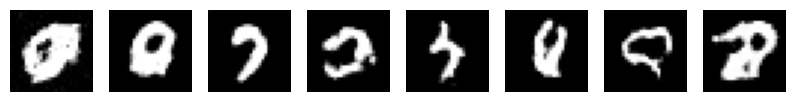

Epoch 5 | Loss: 0.0440: 100%|██████████| 469/469 [00:57<00:00,  8.19it/s]


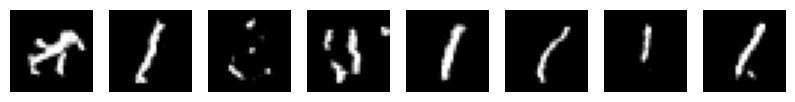

Epoch 6 | Loss: 0.0515: 100%|██████████| 469/469 [00:57<00:00,  8.15it/s]


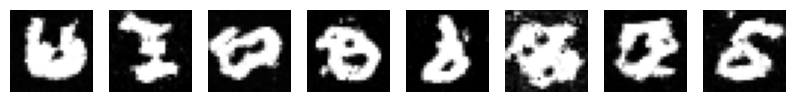

Epoch 7 | Loss: 0.0428: 100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


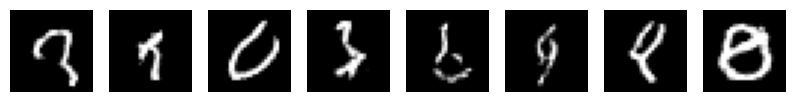

Epoch 8 | Loss: 0.0418: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s]


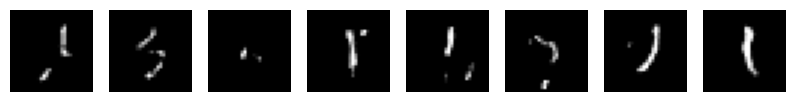

Epoch 9 | Loss: 0.0421: 100%|██████████| 469/469 [00:57<00:00,  8.12it/s]


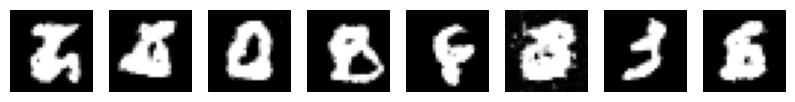

Epoch 10 | Loss: 0.0427: 100%|██████████| 469/469 [00:58<00:00,  7.99it/s]


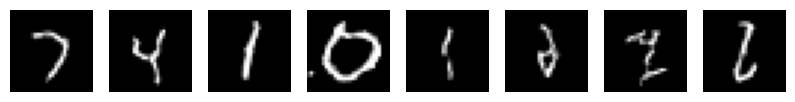

Epoch 11 | Loss: 0.0347: 100%|██████████| 469/469 [00:58<00:00,  8.05it/s]


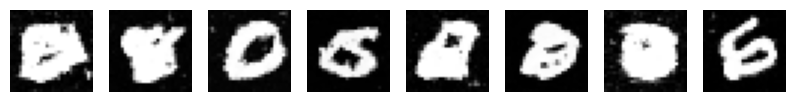

Epoch 12 | Loss: 0.0451: 100%|██████████| 469/469 [00:58<00:00,  8.06it/s]


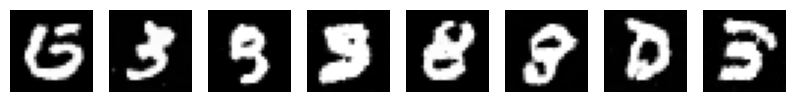

Epoch 13 | Loss: 0.0406: 100%|██████████| 469/469 [00:58<00:00,  8.00it/s]


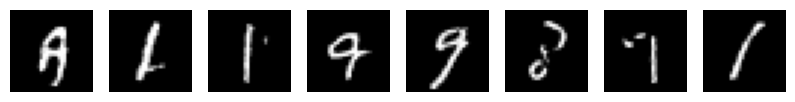

Epoch 14 | Loss: 0.0422: 100%|██████████| 469/469 [00:58<00:00,  7.96it/s]


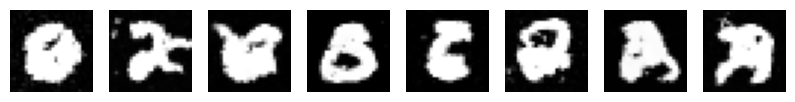

Epoch 15 | Loss: 0.0410: 100%|██████████| 469/469 [00:58<00:00,  7.96it/s]


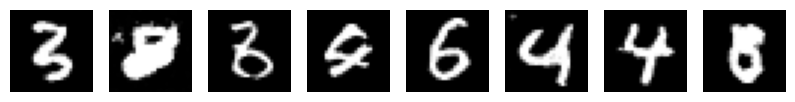

Epoch 16 | Loss: 0.0437: 100%|██████████| 469/469 [00:58<00:00,  7.96it/s]


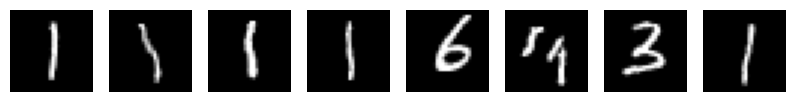

Epoch 17 | Loss: 0.0387: 100%|██████████| 469/469 [00:58<00:00,  7.97it/s]


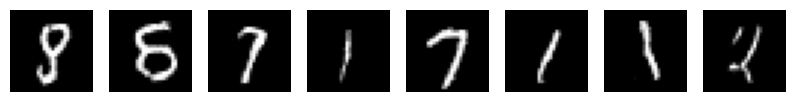

Epoch 18 | Loss: 0.0436: 100%|██████████| 469/469 [00:58<00:00,  7.99it/s]


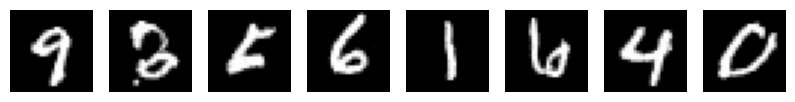

Epoch 19 | Loss: 0.0477: 100%|██████████| 469/469 [00:58<00:00,  7.95it/s]


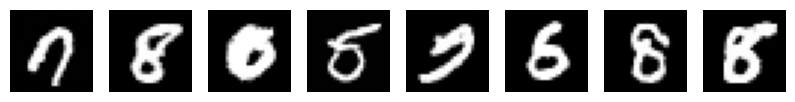

Epoch 20 | Loss: 0.0374: 100%|██████████| 469/469 [00:59<00:00,  7.93it/s]


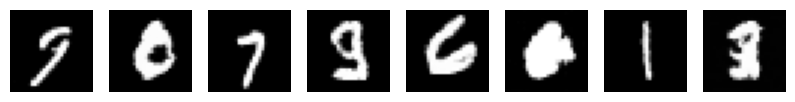

Epoch 21 | Loss: 0.0383: 100%|██████████| 469/469 [00:59<00:00,  7.89it/s]


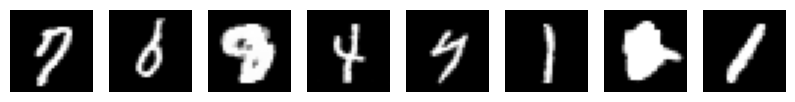

Epoch 22 | Loss: 0.0410: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]


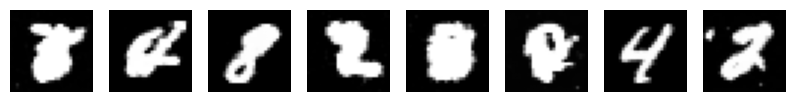

Epoch 23 | Loss: 0.0301: 100%|██████████| 469/469 [00:59<00:00,  7.85it/s]


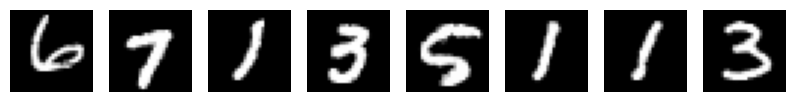

Epoch 24 | Loss: 0.0359: 100%|██████████| 469/469 [00:59<00:00,  7.87it/s]


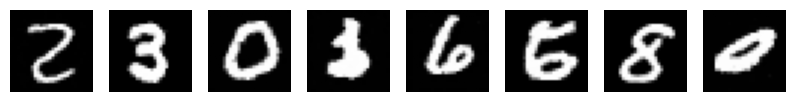

Epoch 25 | Loss: 0.0332: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]


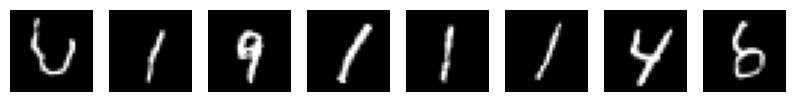

Epoch 26 | Loss: 0.0360: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]


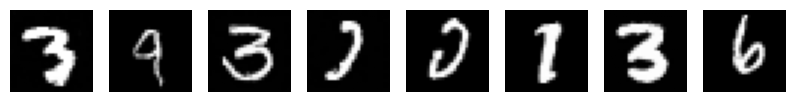

Epoch 27 | Loss: 0.0354: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]


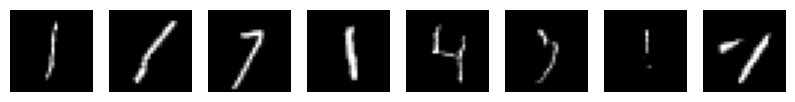

Epoch 28 | Loss: 0.0469: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]


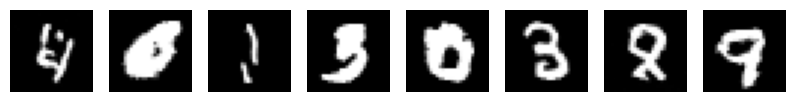

Epoch 29 | Loss: 0.0376: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]


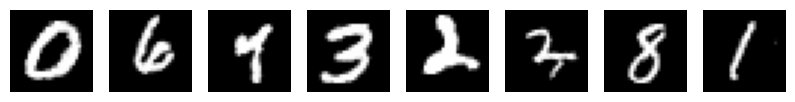

Epoch 30 | Loss: 0.0396: 100%|██████████| 469/469 [01:00<00:00,  7.77it/s]


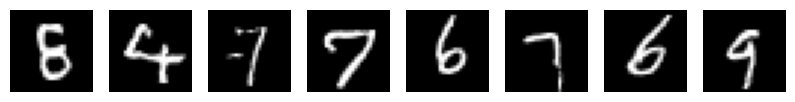

Epoch 31 | Loss: 0.0395: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]


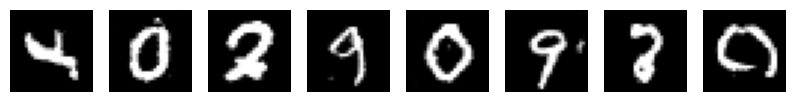

Epoch 32 | Loss: 0.0380: 100%|██████████| 469/469 [01:00<00:00,  7.77it/s]


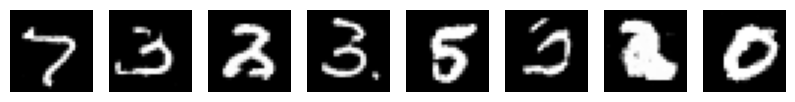

Epoch 33 | Loss: 0.0392: 100%|██████████| 469/469 [01:00<00:00,  7.77it/s]


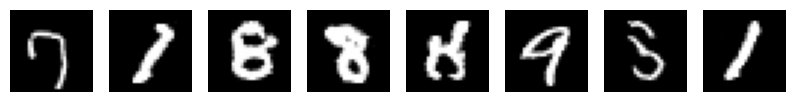

Epoch 34 | Loss: 0.0390: 100%|██████████| 469/469 [01:00<00:00,  7.80it/s]


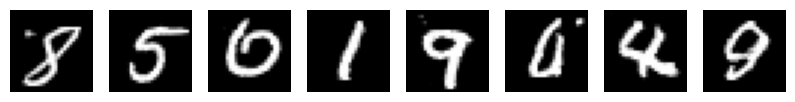

Epoch 35 | Loss: 0.0546: 100%|██████████| 469/469 [01:00<00:00,  7.78it/s]


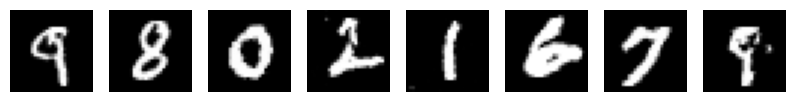

Epoch 36 | Loss: 0.0283: 100%|██████████| 469/469 [01:00<00:00,  7.76it/s]


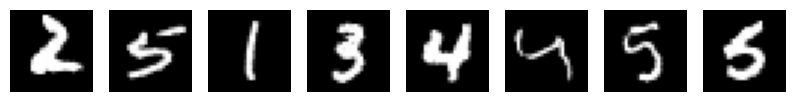

Epoch 37 | Loss: 0.0417: 100%|██████████| 469/469 [01:00<00:00,  7.72it/s]


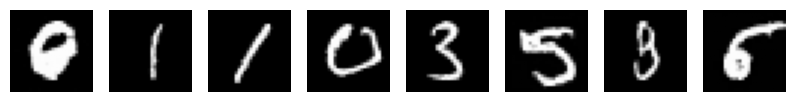

Epoch 38 | Loss: 0.0392: 100%|██████████| 469/469 [01:01<00:00,  7.61it/s]


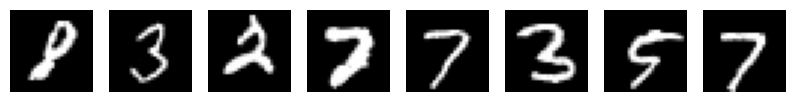

Epoch 39 | Loss: 0.0369: 100%|██████████| 469/469 [01:00<00:00,  7.71it/s]


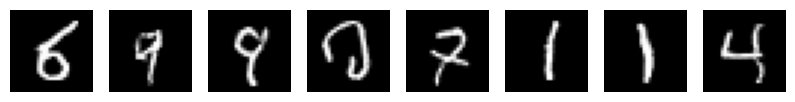

Epoch 40 | Loss: 0.0377: 100%|██████████| 469/469 [01:00<00:00,  7.71it/s]


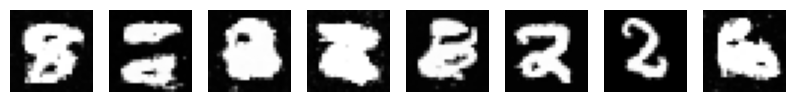

Epoch 41 | Loss: 0.0415: 100%|██████████| 469/469 [01:00<00:00,  7.69it/s]


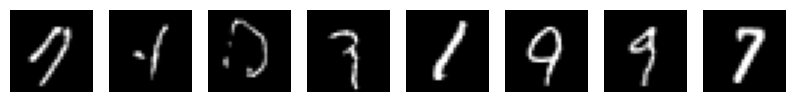

Epoch 42 | Loss: 0.0330: 100%|██████████| 469/469 [01:00<00:00,  7.70it/s]


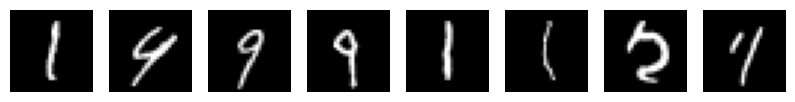

Epoch 43 | Loss: 0.0385: 100%|██████████| 469/469 [01:00<00:00,  7.77it/s]


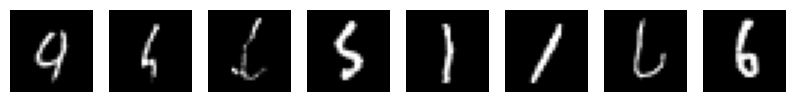

Epoch 44 | Loss: 0.0414: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]


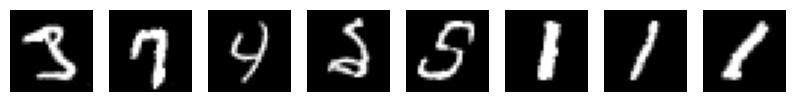

Epoch 45 | Loss: 0.0402: 100%|██████████| 469/469 [01:00<00:00,  7.76it/s]


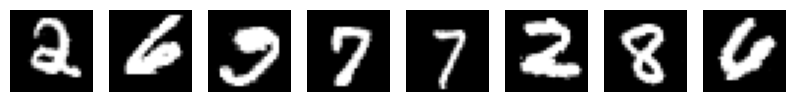

Epoch 46 | Loss: 0.0408: 100%|██████████| 469/469 [01:00<00:00,  7.79it/s]


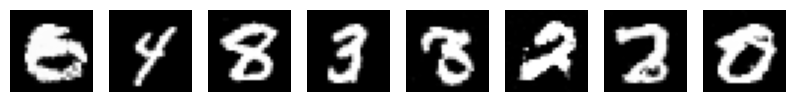

Epoch 47 | Loss: 0.0370: 100%|██████████| 469/469 [01:00<00:00,  7.78it/s]


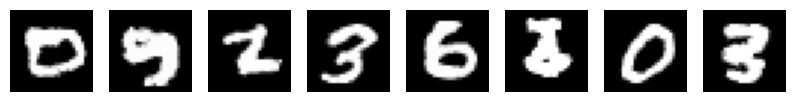

Epoch 48 | Loss: 0.0327: 100%|██████████| 469/469 [01:00<00:00,  7.81it/s]


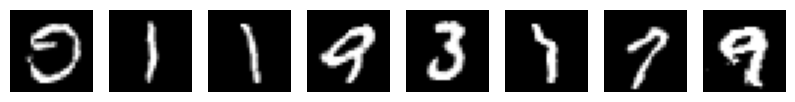

Epoch 49 | Loss: 0.0323: 100%|██████████| 469/469 [01:00<00:00,  7.77it/s]


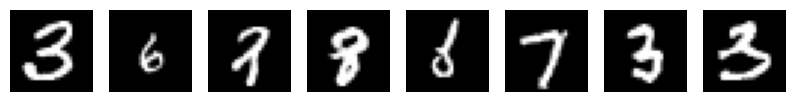

Epoch 50 | Loss: 0.0411: 100%|██████████| 469/469 [00:59<00:00,  7.82it/s]


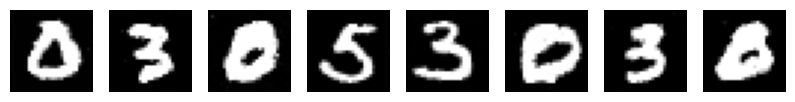

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1. Sinusoidal Time Embedding
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = torch.exp(torch.arange(half, device=device) * -(np.log(10000) / (half - 1)))
        emb = t[:, None] * emb[None, :]
        return torch.cat([emb.sin(), emb.cos()], dim=1)

# 2. Self-Attention Block for Global Coherence
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.SiLU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

# 3. ResBlock with Time Injection
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_proj = nn.Linear(t_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t):
        h = self.norm1(self.conv1(x))
        h = h + self.time_proj(t)[:, :, None, None]
        h = self.act(self.norm2(self.conv2(self.act(h))))
        return h + self.res(x)

# 4. The Complete U-Net
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        t_dim = 128
        self.time_mlp = nn.Sequential(SinusoidalEmbedding(t_dim), nn.Linear(t_dim, t_dim), nn.SiLU())

        self.c0 = ResBlock(1, 64, t_dim)
        self.c1 = ResBlock(64, 128, t_dim)
        self.c2 = ResBlock(128, 256, t_dim)

        self.mid = ResBlock(256, 256, t_dim)
        self.attention = SelfAttention(256) # Added Attention at the bottleneck

        self.u2 = ResBlock(256 + 128, 128, t_dim)
        self.u1 = ResBlock(128 + 64, 64, t_dim)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x0 = self.c0(x, t_emb)
        x1 = self.c1(F.avg_pool2d(x0, 2), t_emb)
        x2 = self.c2(F.avg_pool2d(x1, 2), t_emb)

        m = self.mid(x2, t_emb)
        m = self.attention(m) # Applying Global Attention

        u2 = F.interpolate(m, scale_factor=2, mode='bilinear', align_corners=False)
        u2 = self.u2(torch.cat([u2, x1], dim=1), t_emb)
        u1 = F.interpolate(u2, scale_factor=2, mode='bilinear', align_corners=False)
        u1 = self.u1(torch.cat([u1, x0], dim=1), t_emb)
        return self.out(u1)

# 5. Corrected Diffusion Logic
class Diffusion:
    def __init__(self, T=1000, device='cuda'):
        self.T, self.device = T, device
        # Cosine Schedule prevents "washed out" images
        steps = np.arange(T + 1)
        f = np.cos(((steps / T) + 0.008) / (1.008) * np.pi / 2) ** 2
        alpha_bar = f / f[0]
        self.alpha_bar = torch.tensor(alpha_bar, dtype=torch.float32).to(device)

    @torch.no_grad()
    def ddim_sample(self, model, n=16, steps=50):
        model.eval()
        x = torch.randn(n, 1, 28, 28).to(self.device)
        times = torch.linspace(self.T - 1, 0, steps).long().to(self.device)

        for i in range(len(times)):
            t = times[i]
            prev_t = times[i+1] if i+1 < len(times) else None

            a_t = self.alpha_bar[t].view(-1, 1, 1, 1)
            a_prev = self.alpha_bar[prev_t].view(-1, 1, 1, 1) if prev_t is not None else torch.tensor(1.0).to(self.device)

            eps = model(x, torch.full((n,), t, device=self.device))
            # Deterministic DDIM Step
            pred_x0 = (x - (1 - a_t).sqrt() * eps) / a_t.sqrt()
            x = a_prev.sqrt() * pred_x0 + (1 - a_prev).sqrt() * eps

        return (x.clamp(-1, 1) + 1) / 2 # Scale back to [0,1]

# --- Training Execution ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
diff = Diffusion(device=device)

# Load Data
loader = DataLoader(datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])),
                    batch_size=128, shuffle=True)

for epoch in range(50):
    pbar = tqdm(loader)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, 1000, (x.size(0),), device=device)

        # Forward Noise
        noise = torch.randn_like(x)
        a_bar = diff.alpha_bar[t].view(-1, 1, 1, 1)
        x_t = a_bar.sqrt() * x + (1 - a_bar).sqrt() * noise

        loss = F.mse_loss(model(x_t, t), noise)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

    # Generate samples to verify output clarity
    imgs = diff.ddim_sample(model, n=8, steps=100)
    plt.figure(figsize=(10, 2))
    for i in range(8):
        plt.subplot(1, 8, i+1); plt.imshow(imgs[i, 0].cpu().numpy(), cmap='gray'); plt.axis('off')
    plt.show()